# 🧠 XAI on PCam: Understanding Your Model

Welcome to the final part of the Patch Camelyon project! In this section, we'll dive into **eXplainable AI (XAI)** to better understand how our trained model makes decisions. We’ll focus on the **occlusion method** - a straightforward and widely used technique.

### Notebook Structure 📚

1. Download Pre-Trained Model ⬇️
2. Occlude Patches with Captum 🧩
3. Interpret the Results 📊

**Authors:**<br>
&copy; 2024; Adam Kukučka, Matěj Pekár, Vít Musil

Before we start, let's install the required libraries:

In [1]:
pip install torch torchvision lightning mlflow captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 154.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 130.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 99.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.0/552.0 kB 22.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## 1. Download pre-trained model ⬇️

Before we start with occlusion, we have to download the model and choose patches for occlusion.

<div class="alert alert-success">
    <h3>TASK 1.01</h3>
    <p>
        To start, please enter your MLflow login credentials (username and password) so we can access and download the pre-trained model you'll be using for this analysis.
    </p>
</div>

In [2]:
%env MLFLOW_TRACKING_USERNAME=bednařík_kryštof
%env MLFLOW_TRACKING_PASSWORD=dfgwXV9YKpo

env: MLFLOW_TRACKING_USERNAME=bednařík_kryštof
env: MLFLOW_TRACKING_PASSWORD=dfgwXV9YKpo


To manage and store our models, we rely on [MLflow](https://biomedai-summer-mlflow.dyn.cloud.e-infra.cz/), which you've become familiar with by now. If not, feel free to explore its features! Our model is saved as a PyTorch Lightning checkpoint, ensuring that all the training details and states are preserved.


<style>
code {
    color: purple;
    background-color: #f0f0f0;
}
</style>

<div class="alert alert-success">
    <h3>TASK 1.02</h3>
    <p>
        Your next task is to locate and download the model checkpoint URI, which starts with <code>mlflow-artifacts:</code>. To find this, head over to our <a href="https://biomedai-summer-mlflow.dyn.cloud.e-infra.cz/">MLflow</a> site. Look specifically for the checkpoint associated with the pretrained VGG16 model.
    </p>
</div>

In [8]:
import mlflow


ckpt_path = "mlflow-artifacts:/10/b137747f301547e2acc13aaad5f55ee6/artifacts/checkpoints/epoch=10-step=5632/epoch=10-step=5632.ckpt"  # TODO
ckpt_path = mlflow.artifacts.download_artifacts(ckpt_path)

To load our saved model checkpoint, we can use the `load_from_checkpoint` method provided by the `LightningModule`. However, to successfully load and use the checkpoint, we need to define the exact model architecture used during training. In this case, it's the VGG16 model with a decoder head that we defined back in **Part 1**.

In [9]:
from torch import Tensor, nn


class BinaryClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)
        self.proj = nn.Linear(512, 1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.global_pool(x)  # (B, C, 1, 1)
        x = x.flatten(start_dim=-3, end_dim=-1)  # (B, C)
        x = self.dropout(x)
        x = self.proj(x)
        return x.sigmoid()

In [10]:
import torch
import torchvision
from lightning import LightningModule
from torch import Tensor


class PatchCamelyonModel(LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.backbone = torchvision.models.vgg16().features
        self.decode_head = BinaryClassifier()

    def forward(self, x: Tensor) -> Tensor:
        features = self.backbone(x)
        return self.decode_head(features)

    # NOTE: We don't need to implement the rest for this example.

<div class="alert alert-success">
    <h3>TASK 1.03</h3>
    <p>
        Load the model from checkpoint! For more details, refer to the Lightning <a href="https://lightning.ai/docs/pytorch/stable/common/checkpointing_basic.html">documentation</a>.
    </p>
</div>

In [11]:
model = PatchCamelyonModel.load_from_checkpoint(ckpt_path)  # TODO

Before we can start applying occlusions to our data, we need to load the patches that will be fed into the model. To do so, we’ll use the `PatchCamelyon` dataset class that we created earlier in **Part 1**.

In [12]:
from typing import TypeAlias

import numpy as np
from albumentations import TransformType
from albumentations.pytorch import ToTensorV2
from numpy.typing import NDArray
from torch.utils.data import Dataset


Sample: TypeAlias = tuple[Tensor, Tensor]


class PatchCamelyon(Dataset[Sample]):
    def __init__(
        self, path_x: str, path_y: str, transforms: TransformType | None = None
    ) -> None:
        super().__init__()
        self.x = np.load(path_x, mmap_mode="r")
        self.y = np.load(path_y, mmap_mode="r")
        self.transforms = transforms
        self.to_tensor = ToTensorV2()

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, index: int) -> Sample:
        image: NDArray[np.uint8] = self.x[index]  # (96, 96, 3)
        label: NDArray[np.uint8] = self.y[index]  # (1,)

        if self.transforms is not None:
            image = self.transforms(image=image)["image"]

        return self.to_tensor(image=image)["image"], torch.tensor(label).float()

To ensure our model performs well during occlusions, we need to apply the same normalization to the image patches as we did during training. This ensures that the input patches have the same distribution as the data the model was originally trained on.

In [13]:
import albumentations as A


test_transforms = A.Normalize(
    mean=(178.69278045, 137.28123996, 176.36324185),
    std=(59.91942025, 70.73932419, 54.28812066),
    max_pixel_value=1,
)

We picked for you few patches where the model’s confidence is low (i.e., the predicted value is close to 0.5), making the occlusions more insightful.

<style>
code {
    color: purple;
    background-color: #f0f0f0;
}
</style>

<div class="alert alert-success">
    <h3>TASK 1.04</h3>
    <p>
        Using the provided <code>INDICES</code>, create the following:
        <ul>
            <li><code>inputs</code> - a batch of unnormalized patches.</li>
            <li><code>inputs_normalized</code> - a batch of normalized patches.</li>
            <li><code>targets</code> - a batch of patch labels</li>
        </ul>
        Utilize the <code>PatchCamelyon</code> dataset class and <code>test_transforms</code> for loading the patches and applying normalization.
    </p>
</div>

In [20]:
INDICES = [130, 131, 223, 255, 259, 260]

path_x = "/mnt/data/PatchCamelyon/camelyonpatch_level_2_split_test_x.npy"
path_y = "/mnt/data/PatchCamelyon/camelyonpatch_level_2_split_test_y.npy"

pc = PatchCamelyon(path_x, path_y)
pct = PatchCamelyon(path_x, path_y, test_transforms)

inp, tar, norm = [pc[x][0] for x in INDICES] , [pc[x][1] for x in INDICES], [pct[x][0] for x in INDICES]

inputs: Tensor = torch.stack(inp)  # Unnormalized batch of inputs
targets: Tensor = torch.stack(tar)  # Batch of targets
inputs_normalized: Tensor = torch.stack(norm)  # Normalized batch of inputs

assert isinstance(inputs, Tensor)

## 2. Occlude Patches with Captum 🧩

Occlusion is a technique where parts of an input, like regions of an image, are systematically hidden to observe how this affects a model's output. This helps us understand which features are crucial for the model's decisions by measuring changes in prediction confidence.

<div style="text-align: center;">
<img src="https://miro.medium.com/v2/resize:fit:1200/1*ogpaKqqoD7radhozbmKnfw.png" width="700"/>
</div>


[Captum](https://captum.ai/) is a library designed to provide interpretability and explainability for PyTorch models, offering tools to understand and visualize how different parts of a model or input data influence its predictions.

And yes, Captum includes an Occlusion method as well!

In [33]:
import captum


explainer = captum.attr.Occlusion(model)

Before applying occlusion, it's useful to first run predictions on our input data and measure the time it takes for the model to infer results. This will help us set appropriate parameters for the occlusion process.

<style>
code {
    color: purple;
    background-color: #f0f0f0;
}
</style>

<div class="alert alert-success">
    <h3>TASK 2.01</h3>
    <p>
        Run predictions on your input data and measure the time of model inference in seconds.
    </p>
</div>

In [34]:
model.eval()
import time

start_time = time.time()

with torch.no_grad():
    preds = model(inputs_normalized)

end_time = time.time()

total_seconds = end_time - start_time
print(f"Total time: {total_seconds:.2f}s")

Total time: 0.22s


Helper function that estimate the time required for occlusion calculations based on your model’s inference time and two key occlusion parameters.

In [35]:
def estimate_occlusion_duration(
    inference_time: float,
    sliding_window_shapes: tuple[int, int, int],
    strides: int = 1,
    **_kwargs,
) -> float:
    c, h, w = sliding_window_shapes

    n_windows = (
        ((3 - c) / strides + 1) * ((96 - h) / strides + 1) * ((96 - w) / strides + 1)
    )
    return inference_time * n_windows

Helper function that generates a single color patch that can be used as baseline to occlusion.

In [36]:
def single_color_patch(r: int, g: int, b: int) -> torch.Tensor:
    patch = np.ones((96, 96, 3), dtype=np.uint8)
    patch_normalized = test_transforms(image=patch)["image"]
    return ToTensorV2()(image=patch_normalized)["image"]

<div class="alert alert-success">
    <h3>TASK 2.02</h3>
    <p>
        Check out the <a href="https://captum.ai/api/occlusion.html">Captum documentation</a> for details on the occlusion method. Choose appropriete parameters for the sliding window and other optional arguments, like stride, to optimize execution time.
    </p>
</div>

In [37]:
occlusion_kwargs = {
    "sliding_window_shapes": (3, 15, 15),  # Occluding 15x15 patches across all 3 channels
    "strides": 10,  # Move the window by 10 pixels in height and width
    "baselines": torch.zeros(3, 96, 96)  # Baseline: an all-zero image of the same shape as input
}
print(
    f"Occlusion will take ~{estimate_occlusion_duration(total_seconds, **occlusion_kwargs):.2f} seconds."
)

Occlusion will take ~18.57 seconds.


Now, we’re ready to apply the occlusion method to our model and input data.

In [38]:
attribute = explainer.attribute(inputs_normalized, **occlusion_kwargs)
attribute = attribute.mean(dim=1)

## 3. Interpret the Results 📊

While this section doesn't involve coding, it’s crucial for understanding explainable AI.

<div class="alert alert-success">
    <h3>TASK 3.01</h3>
    <p>
        Take a look at the plotting function. Feel free to make adjustments after obsereving results in <b>TASK 3.02</b>.
    </p>
</div>

In [39]:
import matplotlib.pyplot as plt
import torch


plt.style.use("ggplot")


def plot_occlusions(
    background: torch.Tensor,  # (H, W, C)
    attribute: torch.Tensor,  # (H, W)
    target: torch.Tensor,
    prediction: torch.Tensor,
    **kwargs,
) -> None:
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))
    axs[0].imshow(background)
    axs[0].set_title("Background")

    mask = axs[1].imshow(attribute, cmap=plt.cm.seismic, **kwargs)
    axs[1].set_title("Attribute")

    axs[2].imshow(background)
    axs[2].pcolormesh(attribute, cmap=plt.cm.seismic, alpha=0.5, **kwargs)
    axs[2].set_title("Overlay")

    for ax in axs:
        ax.axis("off")
        ax.ticks = None

    fig.colorbar(mask, ax=axs, location="bottom")
    fig.suptitle(f"Prediction: {prediction.item():.2f} Target: {target.item():.2f}")
    fig.show()

Finally, it's time to examine the occlusion masks! These masks show how the model's prediction changes when different regions of an image are occluded.

For example, suppose you have a patch with a tumor, and the model initially predicts a value of 0.75. If you occlude the part of the patch with the tumor, the prediction drops to 0.25. The change in prediction (0.75 - 0.25 = 0.50) indicates the tumor's importance. Conversely, occluding areas without the tumor should show minimal or negative changes.

By examining these occlusion masks, you can see how different parts of the patch impact the model's predictions. Masks that represent changes can help identify critical areas that influence the model's decision, and shifting these masks by the predicted values can provide insights into the model’s finer predictions.

<div class="alert alert-success">
    <h3>TASK 3.02</h3>
    <p>
        Examine the occlusion masks and observe the effects on different tissue types. Based on these observations, evaluate whether the model seems well-trained. The corners of the patches corners also affect the predicted value, is this the expected behavior? Why? Why not?
    </p>
</div>

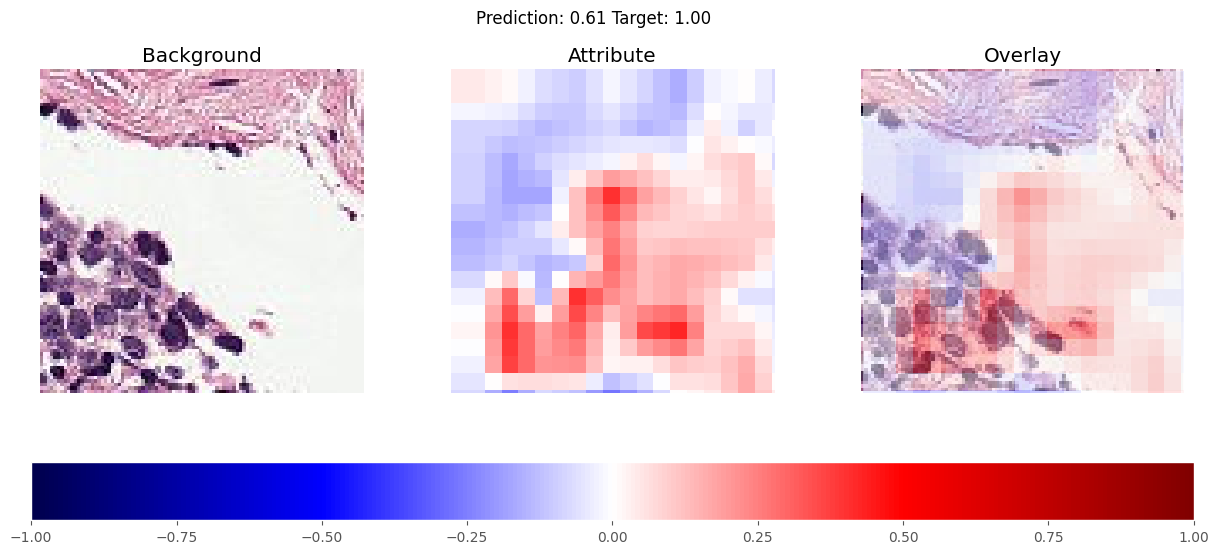

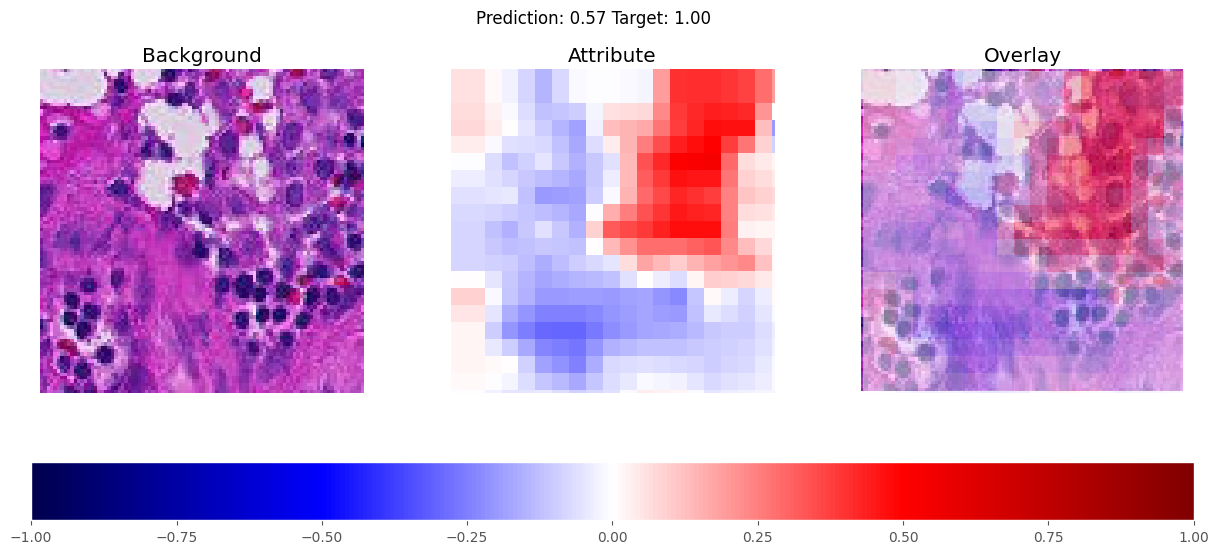

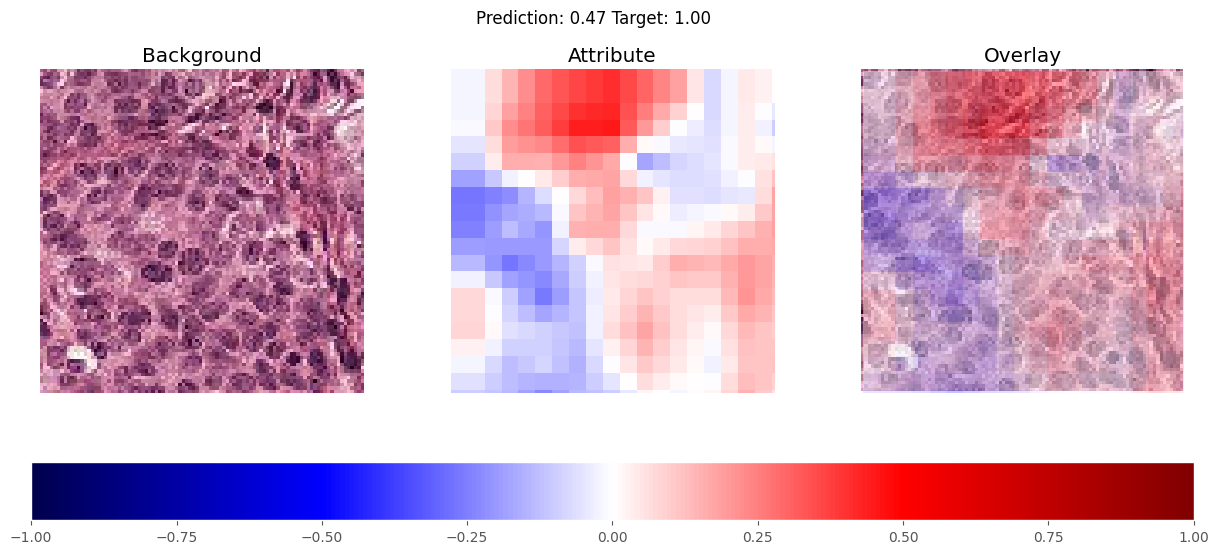

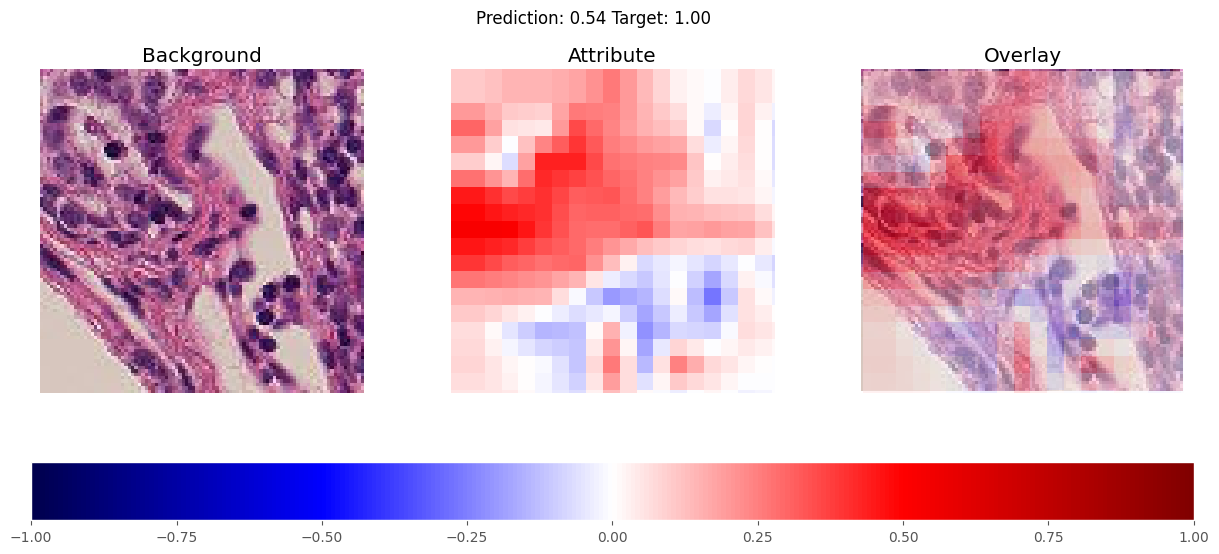

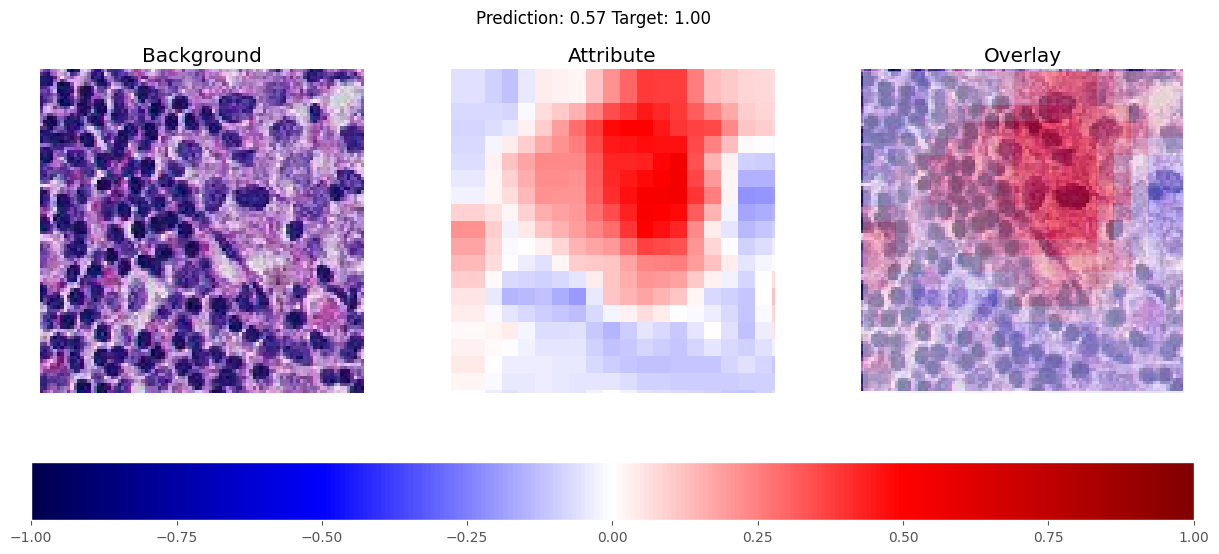

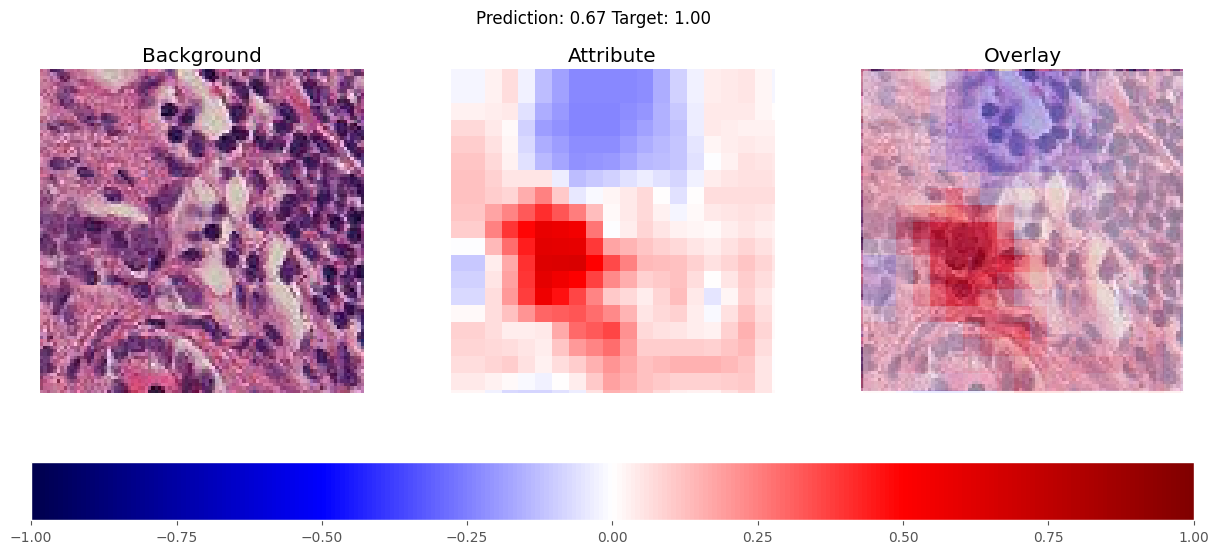

In [40]:
for i in range(len(INDICES)):
    plot_occlusions(
        background=inputs[i].permute(1, 2, 0),
        attribute=attribute[i],
        target=targets[i],
        prediction=preds[i],
        vmin=-1,
        vmax=1,
    )

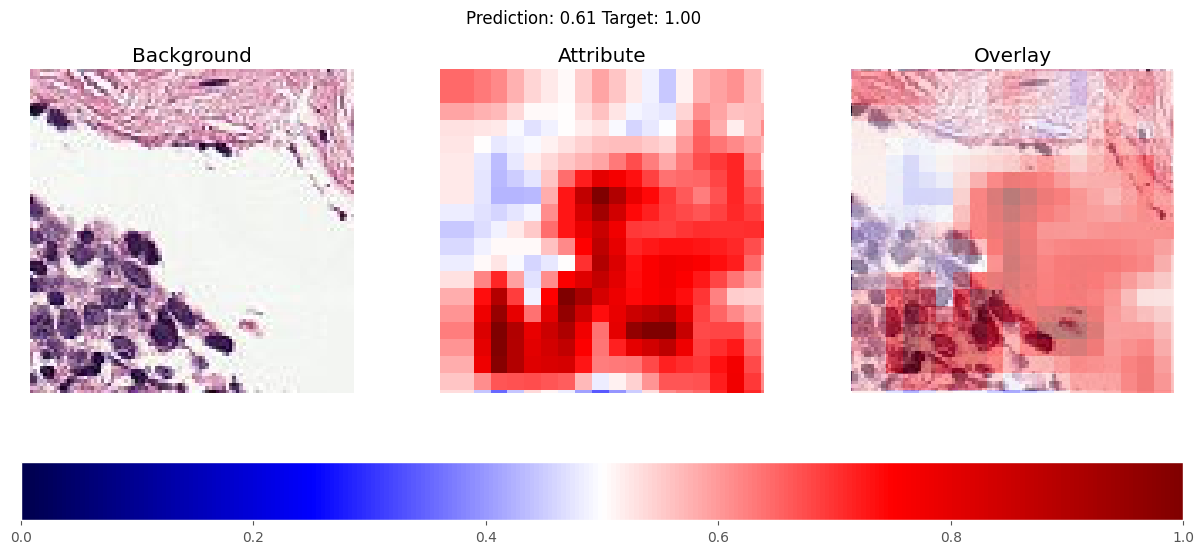

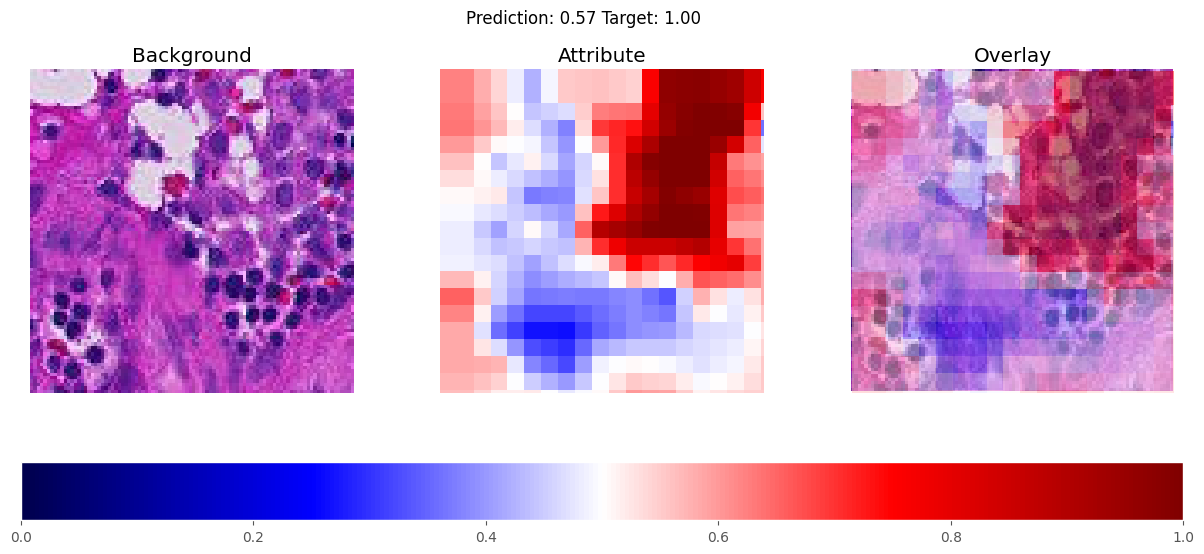

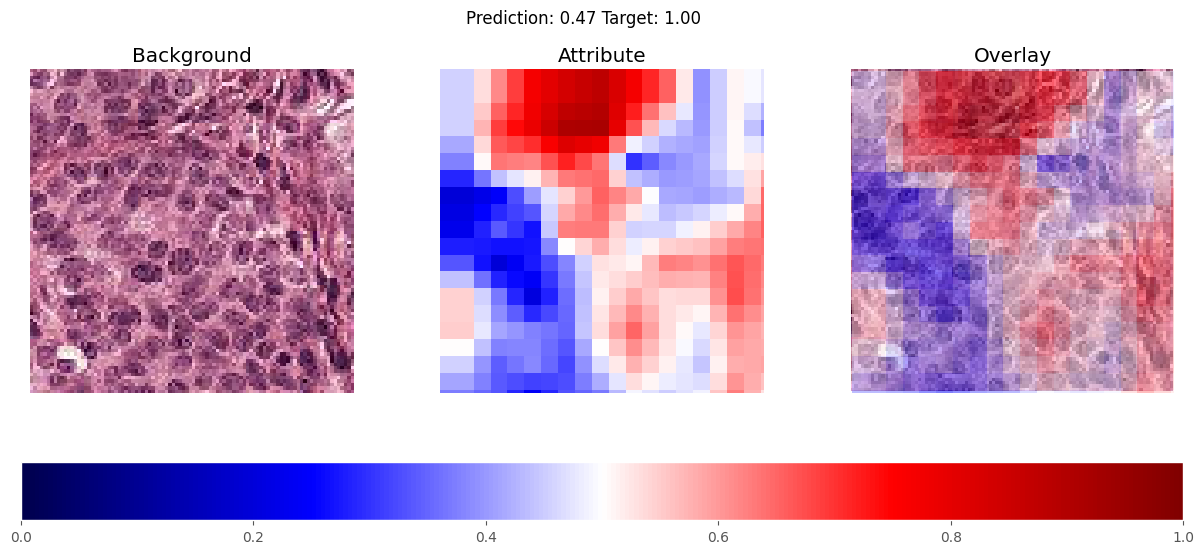

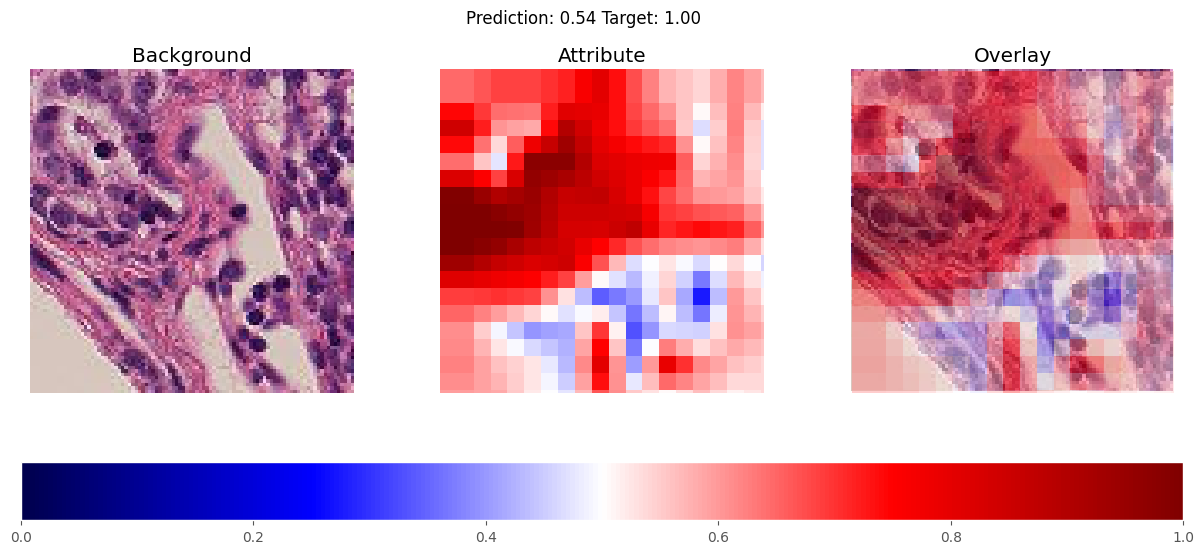

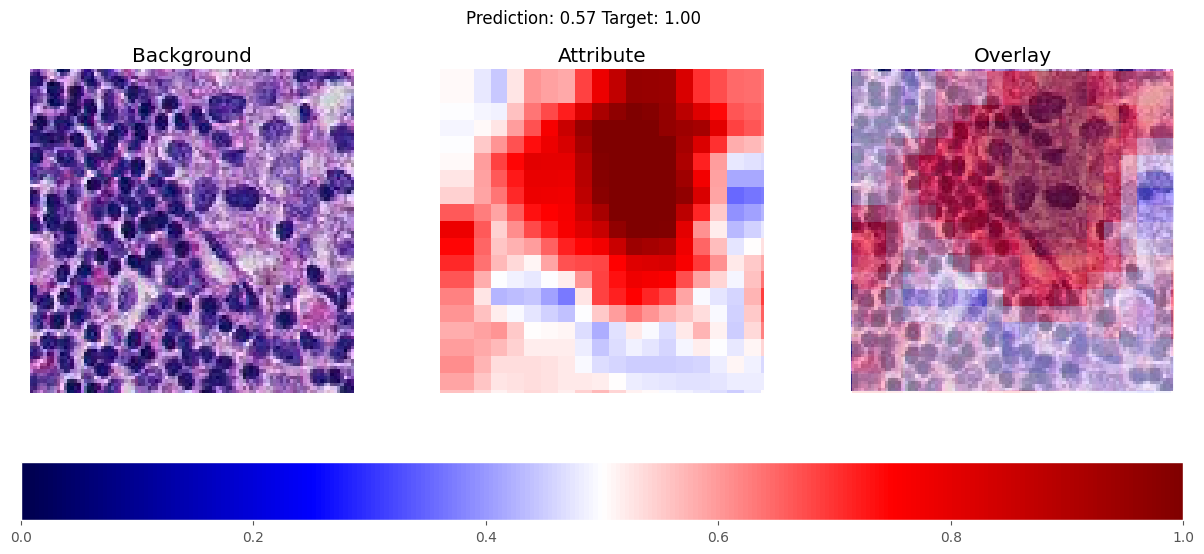

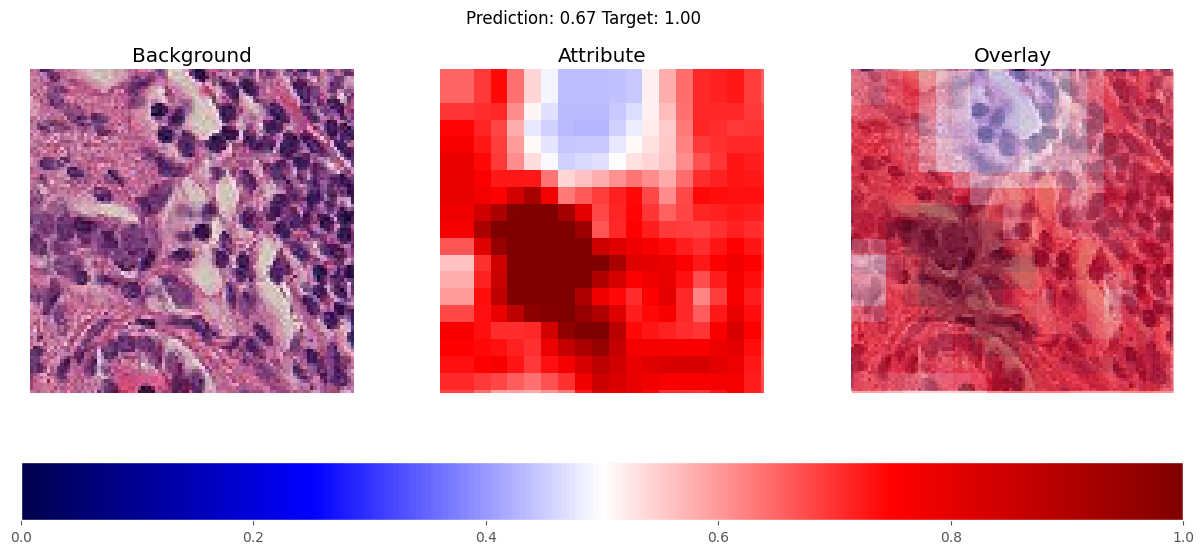

In [41]:
for i in range(len(INDICES)):
    plot_occlusions(
        background=inputs[i].permute(1, 2, 0),
        attribute=attribute[i] + preds[i],
        target=targets[i],
        prediction=preds[i],
        vmin=0,
        vmax=1,
    )